In [1]:
import numpy as np
import shapely
from shapely.geometry import Polygon,MultiPoint
import os
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib inline
def get_result_rectangle(path:str,num):
    files=os.listdir(path)
    rectangles=[[] for i in range(num)]

    for filename in files:
        fin=open(path+"/"+filename)
        file_id=int(filename[:-4][7:])-1
        for line in fin.readlines():
            points=line.strip().split(',')
            if len(points)>=8:
                points=[int(points[p]) for p in range(8)]
                rectangles[file_id].append(points)
    return rectangles

In [2]:
east=np.array(get_result_rectangle("./analyzation_source/evaluation_in_icdar2015/EAST_icdar2015_result",500))
pixel_link=np.array(get_result_rectangle("./analyzation_source/evaluation_in_icdar2015/PixelLink_icdar_result",500))
fots=np.array(get_result_rectangle("./analyzation_source/evaluation_in_icdar2015/FOTS_icdar2015_result",500))
ground_truth=np.array(get_result_rectangle("./analyzation_source/evaluation_in_icdar2015/Challenge4_Test_Task4_GT",500))

In [3]:
area=[1280*720]*500

In [4]:
data_num=500

In [5]:
def Intersect(predicted,ground_truth):
    p_polyes=[Polygon(np.array(p).reshape(4,2)) for p in predicted]
    g_polyes=[Polygon(np.array(gt).reshape(4,2)) for gt in ground_truth]
    intersects=[p.intersection(gt) for p in p_polyes for gt in g_polyes]   
    return cascaded_union(intersects).area

In [6]:
def Area(poly):
    poly=np.array(poly).reshape(4,2)
    poly=Polygon(poly).convex_hull
    return poly.area

def Areaes(polyes):
    polyes=[Polygon(np.array(poly).reshape(4,2)).convex_hull for poly in polyes]
    return cascaded_union(polyes).area

In [7]:
def BestMatchG(predicted,ground_truth):
    if len(predicted)==0:
        return 0
    return max([2*Intersect([p],[ground_truth])/(Area(p)+Area(ground_truth)) for p in predicted])

def BestMatchD(predicted,ground_truth):
    if len(ground_truth)==0:
        return 0
    return max([2*Intersect([predicted],[gt])/(Area(predicted)+Area(gt)) for gt in ground_truth])
def Recall_Precision_Matrix(G,D):
    sigma=np.zeros([len(G),len(D)])
    tao=np.zeros([len(G),len(D)])
    for i,g in enumerate(G):
        for j,d in enumerate(D):
            intersect=Intersect([g],[d])
            sigma[i,j]=intersect/Area(g)
            tao[i,j]=intersect/Area(d)
    return sigma,tao

def MatchG(Gi,tr,sigma):
    k=0
    for s in sigma[Gi]:
        if s>tr:
            k+=1
    if k>1:
        return 1/(1+np.log(k))
    return k

def MatchD(Di,tp,tao):
    k=0
    for s in tao[:,Di].reshape(-1):
        if s>tp:
            k+=1
    if k>1:
        return 1/(1+np.log(k))
    return k

def Confusion_matrix(predicted,ground_truth,area):
    gt_area=Areaes(ground_truth)
    p_area=Areaes(predicted)
    intersect=Intersect(predicted,ground_truth)
    TP=intersect
    FP=p_area-intersect
    TN=area-gt_area-p_area+intersect
    FN=gt_area-intersect
    return TP,FP,TN,FN

In [8]:
def Recall(predicted,ground_truth,method="simple",average="micro",area=[]):
    result=0.0
    num=0
    if method=="simple":
        for i in range(len(ground_truth)):
            G=len(ground_truth[i])
            G_sum=0
            for gt in ground_truth[i]:
                G_sum+=BestMatchG(predicted[i],gt)
            if average=='macro':
                if G!=0:
                    result+=G_sum/G
                num+=1
            else:
                result+=G_sum
                num+=G
    elif method=="DetEval":
        for i in range(len(ground_truth)):
            G=len(ground_truth[i])
            G_sum=0
            sigma,tao=Recall_Precision_Matrix(ground_truth[i],predicted[i])
            for j in range(G):
                G_sum+=MatchG(j,0.5,sigma)
            if average=='macro':
                if G!=0:
                    result+=G_sum/G
                num+=1
            else:
                result+=G_sum
                num+=G
    else:
        i=0
        for p,gt in zip(predicted,ground_truth):
            TP,FP,TN,FN=Confusion_matrix(p,gt,area[i])
            if TP+FN!=0:
                result+=TP/(TP+FN)
            num+=1
            i+=1

    return result/num

def Precision(predicted,ground_truth,method="simple",average="micro",area=[]):
    result=0.0
    num=0
    if method=="simple":
        for i in range(len(ground_truth)):
            P=len(ground_truth[i])
            P_sum=0
            for p in predicted[i]:
                P_sum+=BestMatchD(p,ground_truth[i])
            if average=='macro':
                if P!=0:
                    result+=P_sum/P
                num+=1
            else:
                result+=P_sum
                num+=P
    elif method=="DetEval":
        for i in range(len(predicted)):
            P=len(predicted[i])
            P_sum=0
            sigma,tao=Recall_Precision_Matrix(ground_truth[i],predicted[i])
            for j in range(P):
                P_sum+=MatchD(j,0.5,tao)
            if average=='macro':
                if P!=0:
                    result+=P_sum/P
                num+=1
            else:
                result+=P_sum
                num+=P
    else:
        i=0
        for p,gt in zip(predicted,ground_truth):
            TP,FP,TN,FN=Confusion_matrix(p,gt,area[i])
            if TP+FP!=0:
                result+= TP/(TP+FP)
            num+=1
        i+=1

    return result/num

def Accuracy(predicted,ground_truth,area=[]):
    result=0.0
    num=0
    i=0
    for p,gt in zip(predicted,ground_truth):
        TP,FP,TN,FN=Confusion_matrix(p,gt,area[i])
        result+=(TP+TN)/(TP+FP+FN+TN)
        num+=1
        i+=1
    return result/num
def F1_score(predicted,ground_truth,area=[]):
    result=0.0
    num=0
    i=1
    for p,gt in zip(predicted,ground_truth):
        recall=Recall([p],[gt],method="ours",area=area)
        precision=Precision([p],[gt],method="ours",area=area)
        if recall+precision!=0:
            result+=2*(recall * precision) / (recall + precision)
        num+=1
        i+=1
    return result/num

In [9]:
def evaluate(predicted,ground_truth,area):
    recall_micro=Recall(predicted,ground_truth,average="micro",area=area)
    recall_macro=Recall(predicted,ground_truth,average="macro",area=area)
    precision_micro=Precision(predicted,ground_truth,average="micro",area=area)
    precision_macro=Precision(predicted,ground_truth,average="macro",area=area)
    recall_deteval_micro=Recall(predicted,ground_truth,method="DetEval",average="micro",area=area)
    recall_deteval_macro=Recall(predicted,ground_truth,method="DetEval",average="macro",area=area)
    precision_deteval_micro=Precision(predicted,ground_truth,method="DetEval",average="micro",area=area)
    precision_deteval_macro=Precision(predicted,ground_truth,method="DetEval",average="macro",area=area)
    accuracy=Accuracy(predicted,ground_truth,area=area)
    recall_ours=Recall(predicted,ground_truth,method="ours",area=area)
    precision_ours=Precision(predicted,ground_truth,method="ours",area=area)
    f1_score=F1_score(predicted,ground_truth,area=area)
    print("Recall micro:{}".format(recall_micro))
    print("Recall macro:{}".format(recall_macro))
    print("Precision micro:{}".format(precision_micro))
    print("Precision macro:{}".format(precision_macro))
    print("Recall DetEval micro:{}".format(recall_deteval_micro))
    print("Recall DetEval macro:{}".format(recall_deteval_macro))
    print("just put the predicted result into conderation.")
    print("Precision DetEval micro:{}".format(precision_deteval_micro))
    print("Precision DetEval macro:{}".format(precision_deteval_macro))
    print("ours'method:")
    print("Accuracy:{}".format(accuracy))
    print("Recall:{}".format(recall_ours))
    print("Precision:{}".format(precision_ours))
    print("F1_score :{}".format(f1_score))
    
    return recall_micro,recall_macro,precision_micro,precision_macro,recall_deteval_micro,recall_deteval_macro,precision_deteval_micro,precision_deteval_macro,accuracy,recall_ours,precision_ours,f1_score

In [10]:
east_result=evaluate(east,ground_truth,area)

Recall micro:0.3978892308828582
Recall macro:0.4513718079518589
Precision micro:0.38169980861812003
Precision macro:0.4404876552396115
Recall DetEval micro:0.4853722327343491
Recall DetEval macro:0.5406797582960002
just put the predicted result into conderation.
Precision DetEval micro:0.9149337807668412
Precision DetEval macro:0.8974471154790074
ours'method:
Accuracy:0.9846191337183036
Recall:0.5660555995792264
Precision:0.8385133854271255
F1_score :0.6451203896114323


In [11]:
pixel_result=evaluate(pixel_link,ground_truth,area)

Recall micro:0.414592217076389
Recall macro:0.47356786104161813
Precision micro:0.4086923053572297
Precision macro:0.46953529856416854
Recall DetEval micro:0.47609045517127113
Recall DetEval macro:0.5399495032487771
just put the predicted result into conderation.
Precision DetEval micro:0.9525477888511767
Precision DetEval macro:0.9417979833661123
ours'method:
Accuracy:0.9859786624808787
Recall:0.5911425005442346
Precision:0.88663450005585
F1_score :0.6765543756238008


In [12]:
fots_result=evaluate(fots,ground_truth,area)

Recall micro:0.3296761385917117
Recall macro:0.3950530453730456
Precision micro:0.3028828584628845
Precision macro:0.37887185092950154
Recall DetEval micro:0.45216048970476264
Recall DetEval macro:0.5157055225453355
just put the predicted result into conderation.
Precision DetEval micro:0.7506896080539462
Precision DetEval macro:0.7548186361636492
ours'method:
Accuracy:0.9809098986357646
Recall:0.5541764249131296
Precision:0.7040679410643313
F1_score :0.58497611359559


In [13]:
def show_comparison(east_result,pixel_result,fots_result):
    plt.clf()
    fig = plt.figure(figsize=[40,30])
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.bar(np.array(list(range(len(east_result)))),east_result,0.3)
    ax.bar(np.array(list(range(len(pixel_result))))+0.3,pixel_result,0.3)
    ax.bar(np.array(list(range(len(fots_result))))+0.6,fots_result,0.3)
    ax.set_xticks(np.array(list(range(len(east_result)))))
    ax.set_ylim([0,1.05])
    ax.set_xticklabels(["Recall micro","Recall macro","Precision micro","Precision macro","Recall DetEval micro","Recall DetEval macro","Precision DetEval micro","Precision DetEval macro","Accuracy","Recall","Precision","F1_score "])
    ax.legend(["east","pixel_link","FOTS"],prop={'size': 25})
    plt.plot()
    plt.savefig('./result.png')

<Figure size 432x288 with 0 Axes>

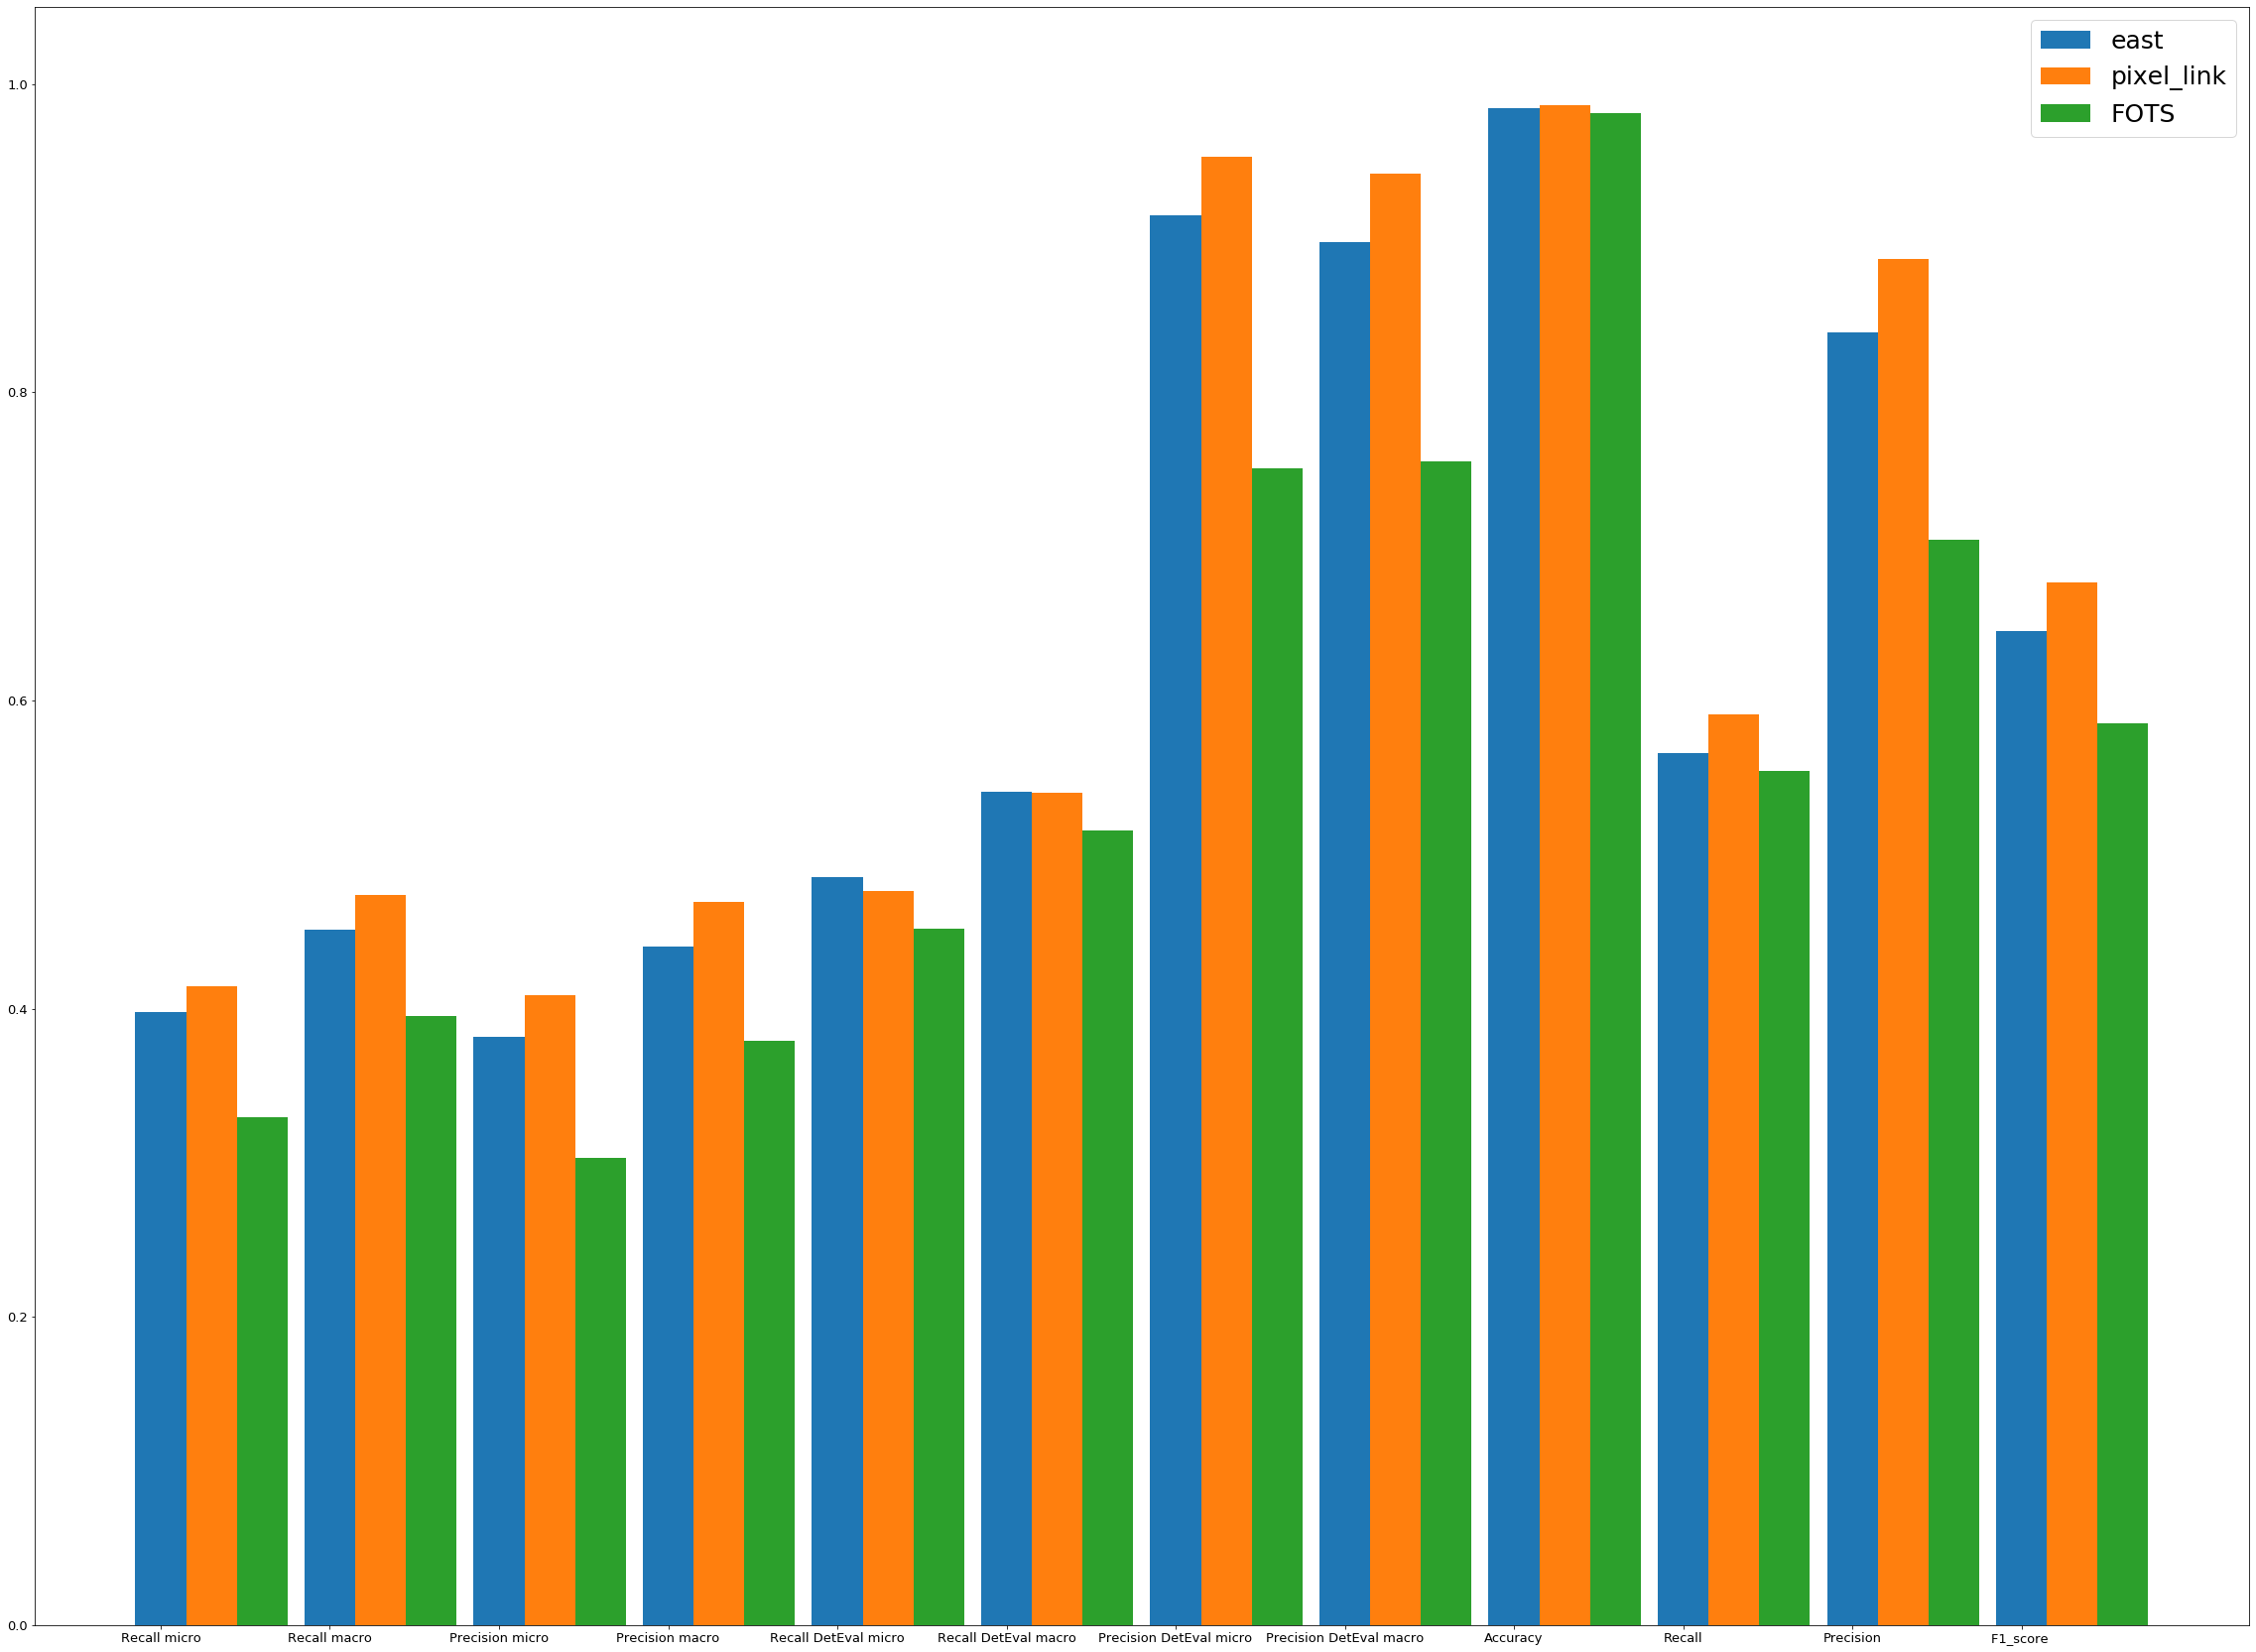

In [14]:
show_comparison(east_result,pixel_result,fots_result)

In [16]:
def get_areas(file:str):
    with open(file,"r") as fout:
        areas=fout.readlines()
    areas=[int(a[:-1]) for a in areas]
    return areas

In [17]:
ours_east=np.array(get_result_rectangle("./analyzation_source/evaluation_in_customized_dataset/EAST_customized_result",178))
ours_pixel_link=np.array(get_result_rectangle("./analyzation_source/evaluation_in_customized_dataset/PixelLink_customized_result",178))
ours_fots=np.array(get_result_rectangle("./analyzation_source/evaluation_in_customized_dataset/FOT_customized_result",178))
ours_ground_truth=np.array(get_result_rectangle("./analyzation_source/evaluation_in_customized_dataset/customized_dataset_GT",178))
areas=get_areas("./analyzation_source/evaluation_in_customized_dataset/areas.txt")

In [144]:
print(len(areas))

178


In [145]:
ours_east_result=evaluate(ours_east,ours_ground_truth,areas)

Recall micro:0.30164137316783796
Recall macro:0.1675448999629211
Precision micro:0.37771045723922186
Precision macro:0.25538517797833743
Recall DetEval micro:0.2510176390773406
Recall DetEval macro:0.12222374850203947
just put the predicted result into conderation.
Precision DetEval micro:0.48556434727039716
Precision DetEval macro:0.44181192862716406
ours'method:
Accuracy:0.3955933489930929
Recall:0.17933655033952062
Precision:0.4425319751899599
F1_score :0.22349556914232319


In [146]:
ours_pixel_result=evaluate(ours_pixel_link,ours_ground_truth,areas)

Recall micro:0.314876608229771
Recall macro:0.14747473052683163
Precision micro:0.42434104043501103
Precision macro:0.25712328039867477
Recall DetEval micro:0.24515333706776846
Recall DetEval macro:0.09455527648009157
just put the predicted result into conderation.
Precision DetEval micro:0.46321582547433887
Precision DetEval macro:0.5276085416983439
ours'method:
Accuracy:0.31269081446887304
Recall:0.15740593356288568
Precision:0.5161034555089103
F1_score :0.20636898463980086


In [147]:
ours_fots_result=evaluate(ours_fots,ours_ground_truth,areas)

Recall micro:0.08211271130956499
Recall macro:0.10328520627038042
Precision micro:0.09116227030508575
Precision macro:0.1264360238053068
Recall DetEval micro:0.06401795416322834
Recall DetEval macro:0.06850661778923696
just put the predicted result into conderation.
Precision DetEval micro:0.4986002964874167
Precision DetEval macro:0.3711598878579237
ours'method:
Accuracy:0.42832646134912244
Recall:0.09953322408650464
Precision:0.3640492474894299
F1_score :0.12108651319913113


<Figure size 432x288 with 0 Axes>

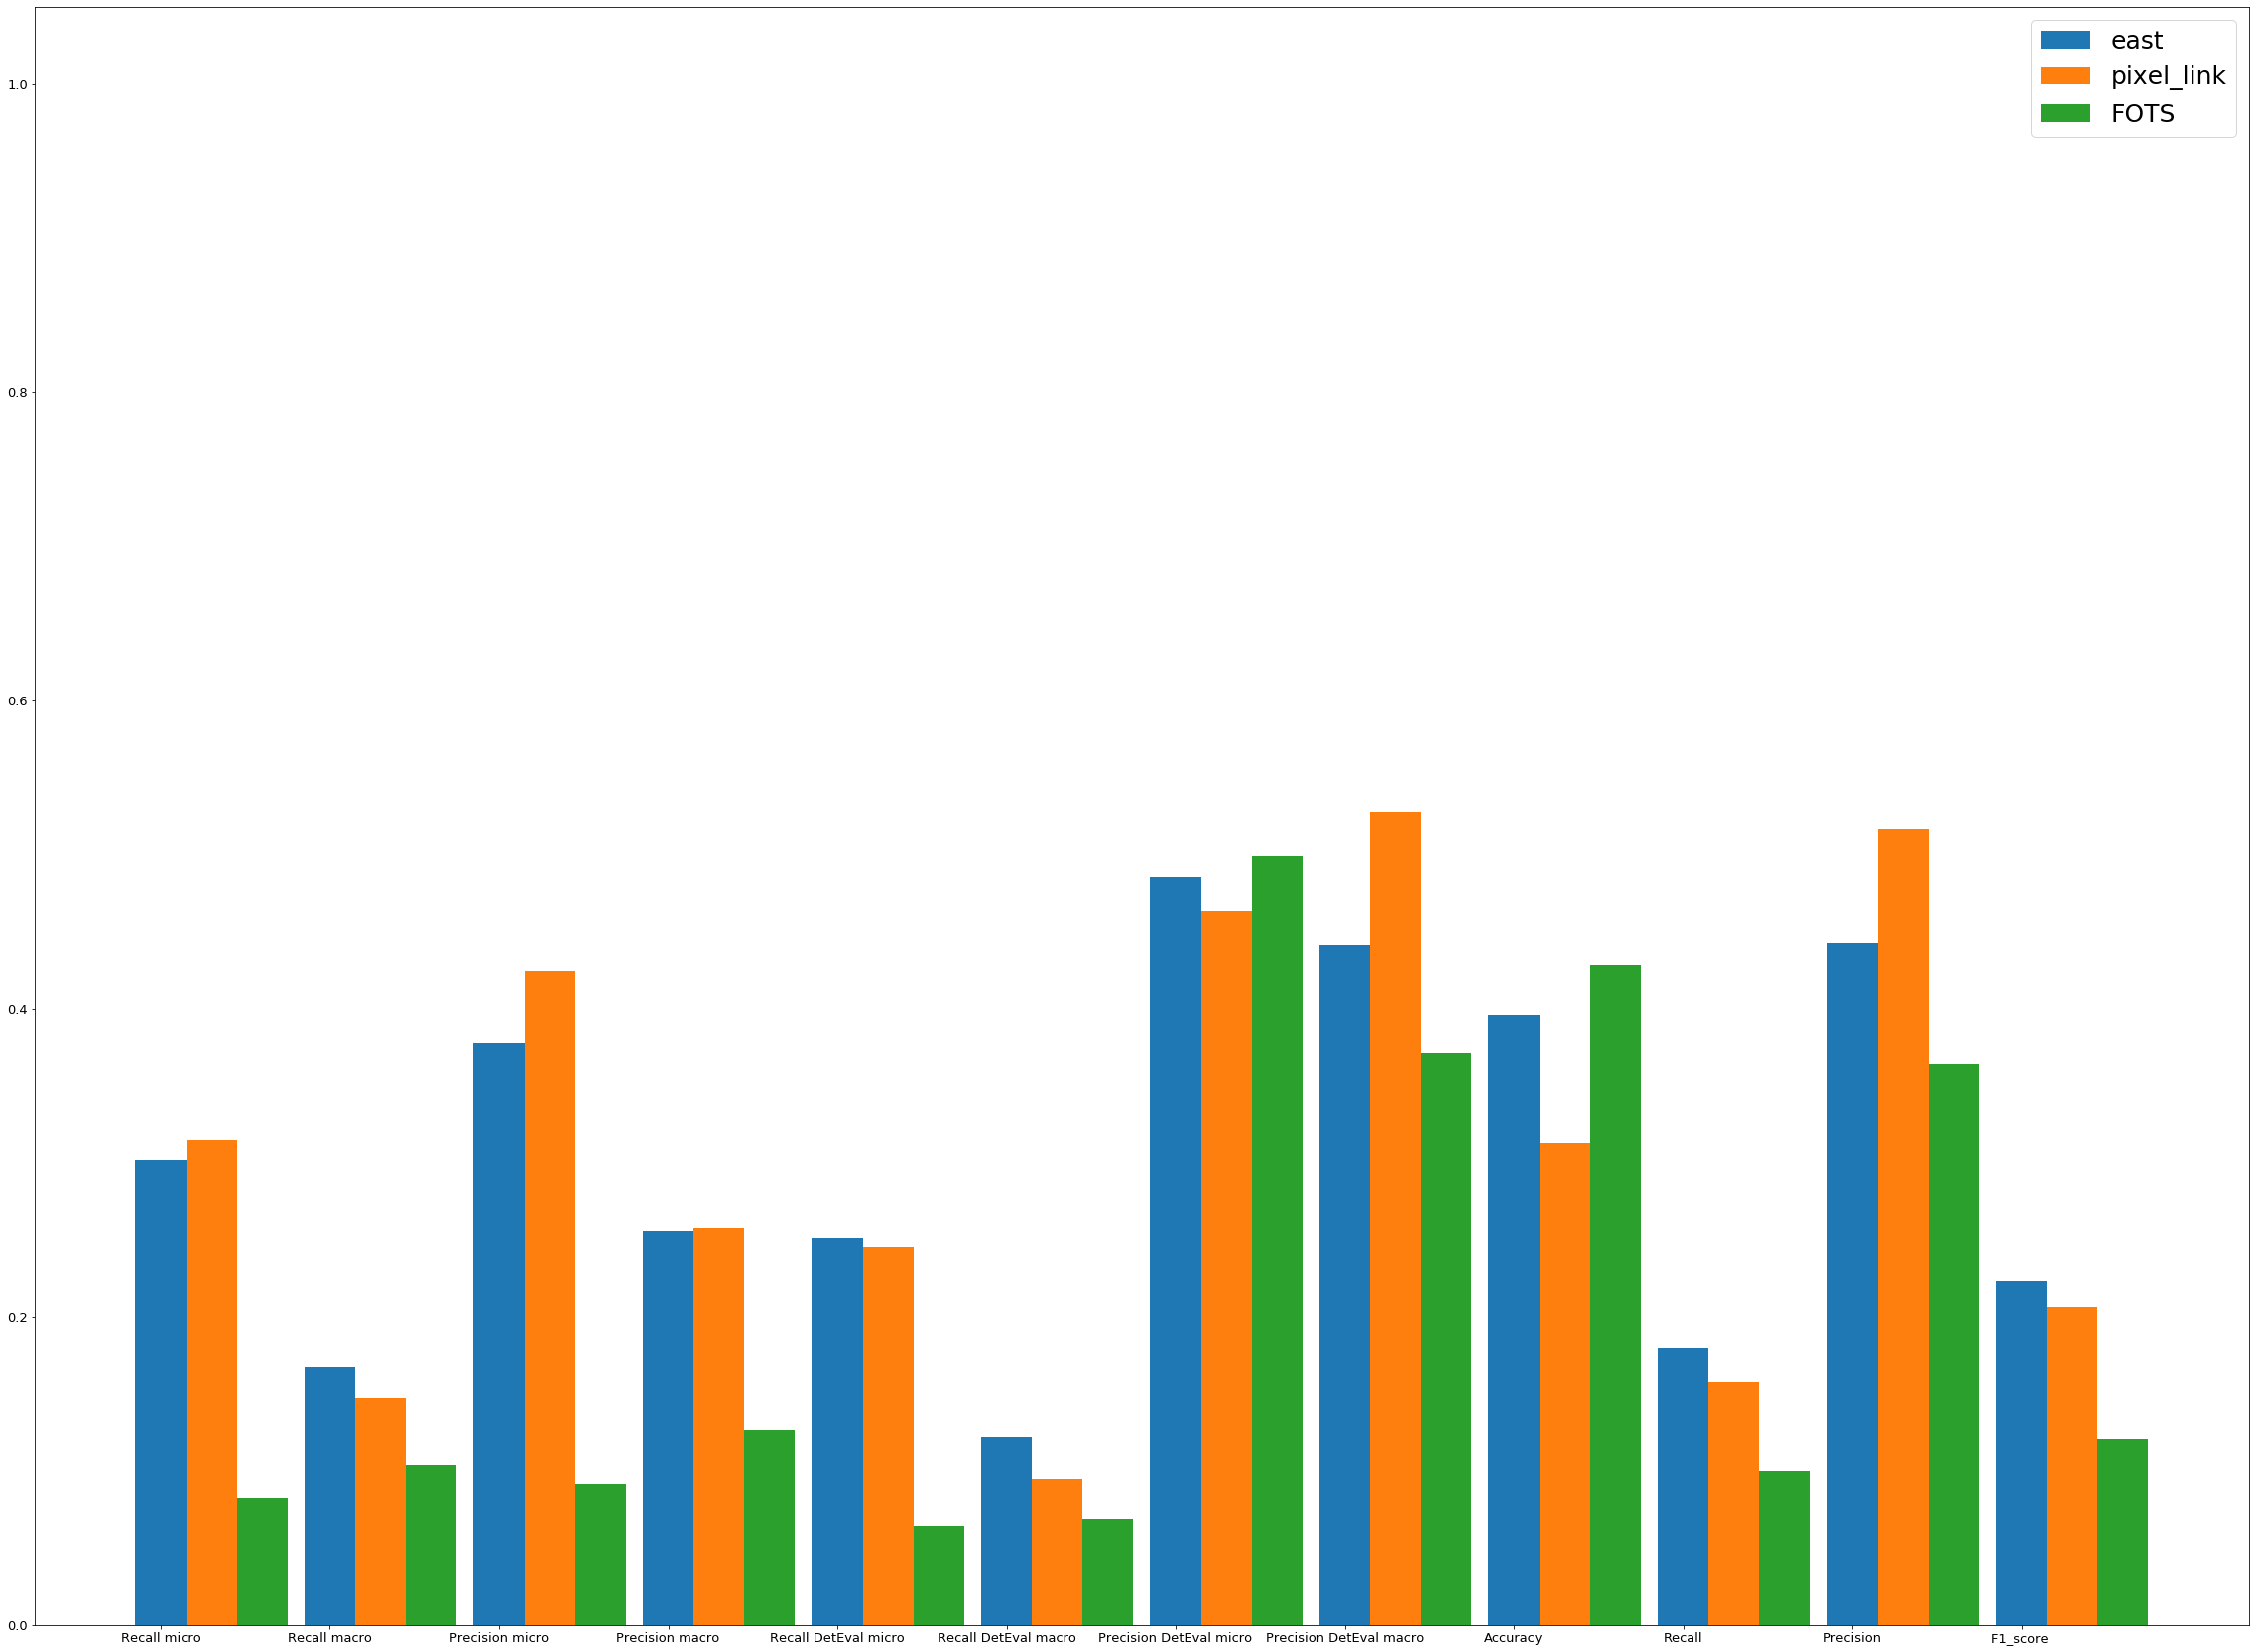

In [159]:
show_comparison(ours_east_result,ours_pixel_result,ours_fots_result)